In [1]:
# ------------------------------------------------------------------------- #
# Import libraries
# ------------------------------------------------------------------------- #
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import nlopt
import sys
from SiPANN import SiP
from scipy import io as sio
from scipy.signal import find_peaks

INFO:tensorflow:Restoring parameters from /Users/alechammond/Documents/GitHub/SiP-ANN/SiPANN/ANN/TIGHT_GAP/model
INFO:tensorflow:Restoring parameters from /Users/alechammond/Documents/GitHub/SiP-ANN/SiPANN/ANN/TIGHT_STRAIGHT/model
INFO:tensorflow:Restoring parameters from /Users/alechammond/Documents/GitHub/SiP-ANN/SiPANN/ANN/TIGHT_BENT/model


In [2]:
# ------------------------------------------------------------------------- #
# Tuning parameters
# ------------------------------------------------------------------------- #

# Initial algorithm starting points
radius        = 12
couplerLength = 4.5
gap           = 0.2
width         = 0.5
thickness     = 0.2

# Peak thresholding
peakThreshold = 0.3

# Value bounds
radiusMin        = 11;   radiusMax        = 13
couplerLengthMin = 4;    couplerLengthMax = 5
widthMin         = 0.45; widthMax         = 0.55
thicknessMin     = 0.18; thicknessMax     = 0.25

algorithmGlobal = nlopt.GN_DIRECT_L
algorithmLocal  = nlopt.LN_SBPLX

maxtime_global  = 120
maxtime_local   = 120

polyOrder = 3

In [3]:
# ------------------------------------------------------------------------- #
# Load relevant info
# ------------------------------------------------------------------------- #

# Load the measurement data
data       = sio.loadmat('test.mat')
power      = 10 ** (np.squeeze(data['powerMod']) / 10)
wavelength = np.squeeze(data['wavelength']) * 1e6

In [4]:
# ------------------------------------------------------------------------- #
# Preprocessing
# ------------------------------------------------------------------------- #

# Pull the coupler and loss data
a,b,w = SiP.extractor(power,wavelength)

# Fit the coupler and loss data
ap = np.polyfit(w, a, polyOrder)
az = np.poly1d(ap)
bp = np.polyfit(w, b, polyOrder)
bz = np.poly1d(bp)

# Identify the peaks for the measurement data
peaks, _        = find_peaks(1-power,height=peakThreshold)
wavelengthPeaks = wavelength[peaks]
numPeaks        = peaks.size

In [5]:
# ------------------------------------------------------------------------- #
# Relevant functions
# ------------------------------------------------------------------------- #

def plotResult(radius,couplerLength,width,thickness):
    
    gap = 0.2

    E, alpha, t = SiP.racetrack_AP_RR_TF(wavelength,radius=radius,
    couplerLength=couplerLength,gap=gap,width=width,
    thickness=thickness)

    # get the transmission spectrum
    throughPort = np.abs(np.squeeze(E)) ** 2

    plt.figure()
    plt.plot(wavelength,power)
    plt.plot(wavelength,throughPort)
    plt.xlabel('Wavelength ($\mu$m)')
    plt.ylabel('Power (a.u.)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    return

# Define a cost function that can locate the correct FSR
def costFunction_FSR(x,grad):
    radius        = x[0]
    couplerLength = x[1]
    gap           = 0.2
    width         = x[2]
    thickness     = x[3]

    # Evaluate the functin
    E, alpha, t = SiP.racetrack_AP_RR_TF(wavelength,radius=radius,
    couplerLength=couplerLength,gap=gap,width=width,
    thickness=thickness)

    # get the transmission spectrum
    throughPort = np.abs(np.squeeze(E)) ** 2

    # Pull the peaks from the simulation
    peaksSim, _ = find_peaks(1-throughPort,height=peakThreshold)

    # calculate the number of peaks
    wavelengthSim = wavelength[peaksSim]
    powerSim      = throughPort[peaksSim]

    if wavelengthSim.size > numPeaks:
        wavelengthSim = wavelengthSim[0:numPeaks]
        powerSim      = powerSim[0:numPeaks]
    elif wavelengthSim.size < numPeaks:
        wavelengthSim = np.append(wavelengthSim,np.zeros((numPeaks-wavelengthSim.size,)))
        powerSim      = np.append(powerSim,np.zeros((numPeaks-powerSim.size,)))
    # Estimate the error
    error = np.sum(np.abs(wavelengthSim - wavelengthPeaks) ** 2)
    print(error)
    return error

def costFunction_loss(params,gapA,x,grad):
    radius        = params[0]
    couplerLength = params[1]
    gap           = gapA[0]
    width         = params[2]
    thickness     = params[3]

    # Evaluate the functin
    E, alpha, t = SiP.racetrack_AP_RR_TF(wavelength,radius=radius,
    couplerLength=couplerLength,gap=gap,width=width,
    thickness=thickness,loss=x)

    throughPort = np.abs(np.squeeze(E)) ** 2

    ap_sim = np.polyfit(wavelength, alpha, polyOrder)
    az_sim = np.poly1d(ap_sim)

    error = np.mean(np.abs(az_sim(wavelength)-az(wavelength)) ** 2 )
    
    print(error)
    plt.figure()
    plt.plot(w,a,'o')
    plt.plot(wavelength,az_sim(wavelength))

    plt.show()

    return error 
def costFunction_coupling(params,x,grad):
    radius        = params[0]
    couplerLength = params[1]
    gap           = x[0]
    width         = params[2]
    thickness     = params[3]

    # Evaluate the functin
    E, alpha, t = SiP.racetrack_AP_RR_TF(wavelength,radius=radius,
    couplerLength=couplerLength,gap=gap,width=width,
    thickness=thickness)

    throughPort = np.abs(np.squeeze(E)) ** 2

    bp_sim = np.polyfit(wavelength, t, polyOrder)
    bz_sim = np.poly1d(bp_sim)

    error = np.mean(np.abs(bz_sim(w)-b) ** 2 )
    print(error)
    plt.figure()
    plt.plot(w,b,'o')
    plt.plot(wavelength,bz_sim(wavelength))

    plt.show()

    return error
def plotFinal(x0,y0,z0):
    radius        = x0[0]
    couplerLength = x0[1]
    gap           = y0[0]
    width         = x0[2]
    thickness     = x0[3]
    loss          = z0

    E, alpha, t = SiP.racetrack_AP_RR_TF(wavelength,radius=radius,
    couplerLength=couplerLength,gap=gap,width=width,
    thickness=thickness,loss=loss)

    # get the transmission spectrum
    throughPort = np.abs(np.squeeze(E)) ** 2

    plt.figure(figsize=(7,7))
    plt.subplot(2,2,1)
    plt.plot(wavelength,power)
    plt.plot(wavelength,throughPort)
    plt.xlabel('Wavelength ($\mu$m)')
    plt.ylabel('Power (a.u.)')
    plt.grid(True)
    
    plt.subplot(2,2,3)
    plt.plot(wavelength,10*np.log10(power))
    plt.plot(wavelength,10*np.log10(throughPort))
    plt.xlabel('Wavelength ($\mu$m)')
    plt.ylabel('Power (dB)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    return
    return

In [6]:
# ------------------------------------------------------------------------- #
# Step 1: Find the right FSR
# ------------------------------------------------------------------------- #
print('=================')
print('FSR')


lowerBounds = [radiusMin,couplerLengthMin,widthMin,thicknessMin]
upperBounds = [radiusMax,couplerLengthMax,widthMax,thicknessMax]
x0          = [radius,couplerLength,width,thickness]

numParams = len(x0)

# Do a global optimization first
opt = nlopt.opt(algorithmGlobal, numParams)
opt.set_lower_bounds(lowerBounds)
opt.set_upper_bounds(upperBounds)
opt.set_min_objective(costFunction_FSR)
opt.set_maxtime(maxtime_global)
x0 = opt.optimize(x0)
print('=================')
print('Global')
print(x0)
print(costFunction_FSR(x0,00))

# Then do a local optimization
opt = nlopt.opt(algorithmLocal, numParams)
opt.set_lower_bounds(lowerBounds)
opt.set_upper_bounds(upperBounds)
opt.set_min_objective(costFunction_FSR)
opt.set_maxtime(maxtime_local)
x0 = opt.optimize(x0)
print('=================')
print('Local')
print(x0)
print(costFunction_FSR(x0,0))

FSR
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
Global
[12.     4.5    0.5    0.215]
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
34.9667759034
Local
[12.0625   4.53125  0.50625  0.215  ]
34.9667759034
34.9667759034


Coupling
0.0016527299917977133


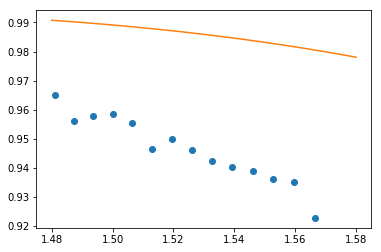

0.002367966071056286


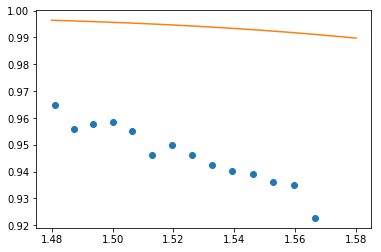

0.00035554229710724915


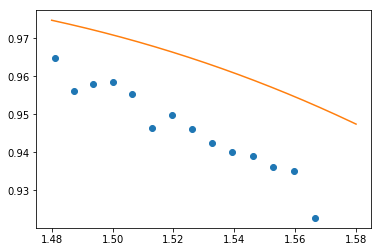

0.0027443223163300784


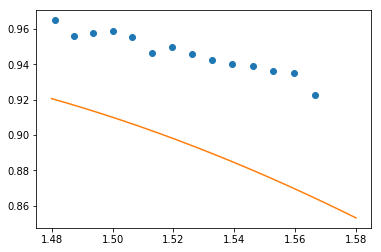

0.0027443223163300784


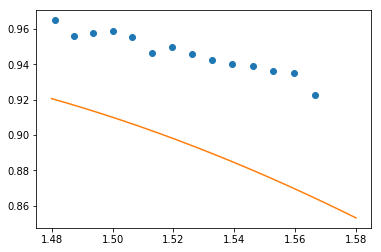

0.0010645023961633562


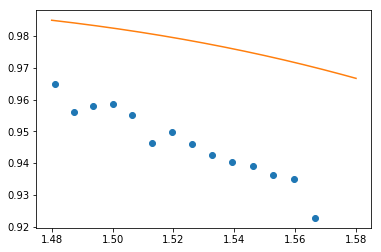

4.812152136203073e-05


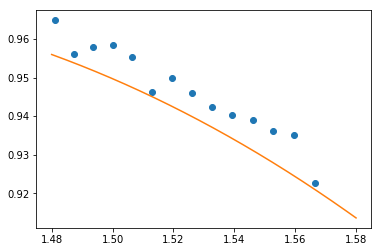

0.0027443223163300784


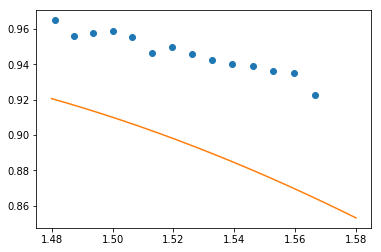

0.0027443223163300784


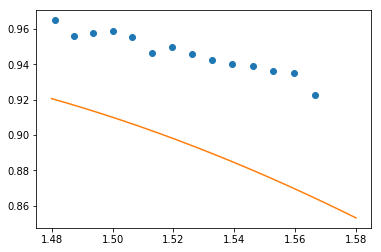

7.28116417286829e-05


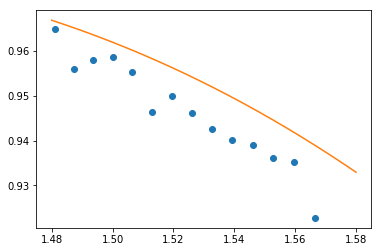

0.00067428293639361


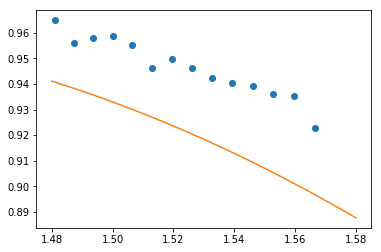

7.28116417286829e-05


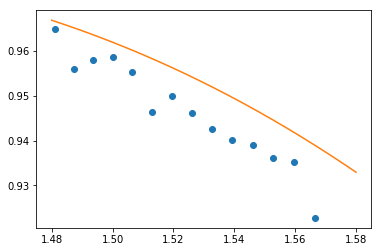

1.0285850411716953e-05


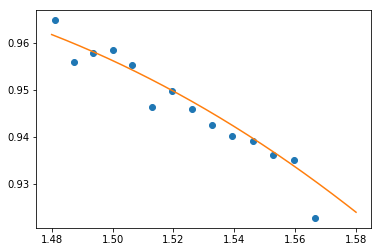

7.28116417286829e-05


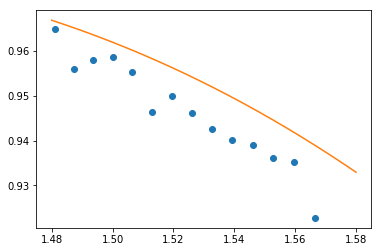

1.3613425524806604e-05


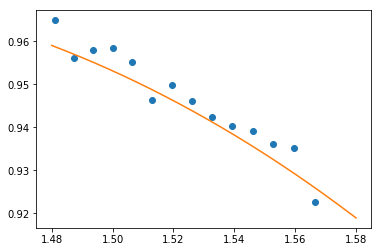

3.178021560982049e-05


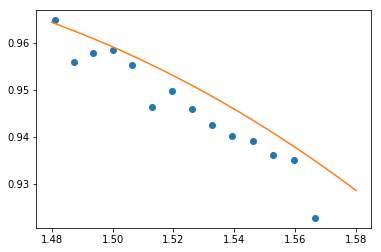

1.3613425524806604e-05


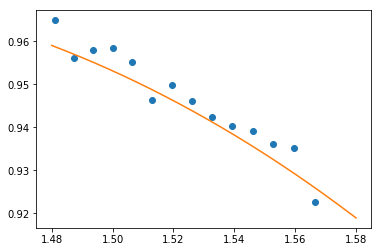

8.476768610481555e-06


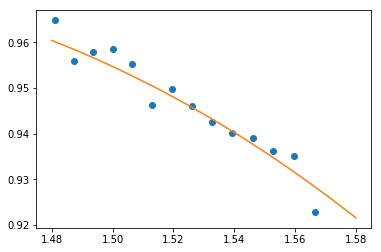

1.3613425524806604e-05


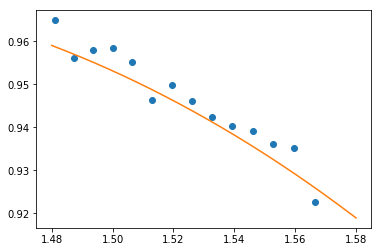

8.562064626135488e-06


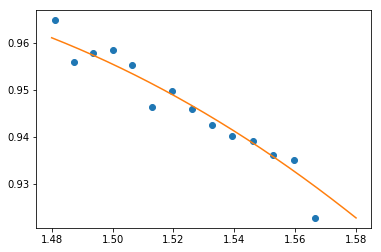

1.0126799976210454e-05


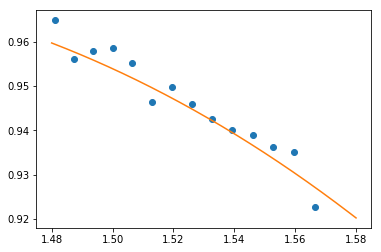

8.562064626135488e-06


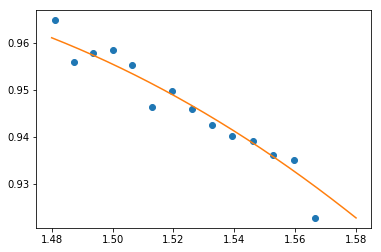

Local
[0.1296875]
8.476768610481555e-06


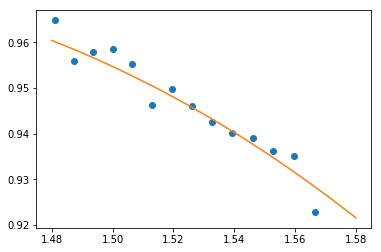

8.476768610481555e-06


In [7]:
# ------------------------------------------------------------------------- #
# Step 2: Find the right coupling
# ------------------------------------------------------------------------- #
print('===============')
print('Coupling')

costFunction_coupling_mode = lambda x_param,grad: costFunction_coupling(x0,x_param,grad)

lowerBounds = [0.1]
upperBounds = [0.3]
y0 = [0.2]
numParams = len(y0)

opt = nlopt.opt(algorithmLocal, numParams)
opt.set_lower_bounds(lowerBounds)
opt.set_upper_bounds(upperBounds)
opt.set_min_objective(costFunction_coupling_mode)
opt.set_maxtime(maxtime_local)
y0 = opt.optimize(y0)
print('=================')
print('Local')
print(y0)
print(costFunction_coupling_mode(y0,0))

Loss
Local
[  9.27729299 -37.26335585  48.83695706 -19.7594544 ]
1.189145067010426e-27


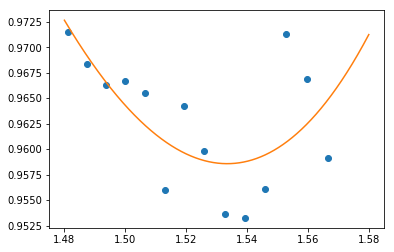

1.189145067010426e-27


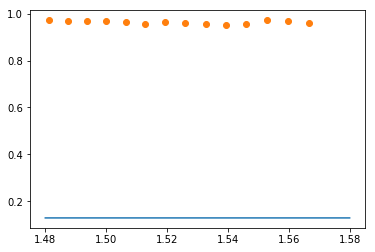

In [8]:
# ------------------------------------------------------------------------- #
# Step 3: Find the right loss
# ------------------------------------------------------------------------- #
print('==============')
print('Loss')

costFunction_loss_mode = lambda x_param,grad: costFunction_loss(x0,y0,x_param,grad)
lowerBounds = np.zeros((polyOrder+1,)) - 100
upperBounds = np.zeros((polyOrder+1,)) + 100
z0          = ap

numParams = len(z0)

# Just do a local optimization
opt = nlopt.opt(algorithmLocal, numParams)
opt.set_lower_bounds(lowerBounds)
opt.set_upper_bounds(upperBounds)
opt.set_min_objective(costFunction_loss_mode)
opt.set_maxtime(maxtime_local)
#z0 = opt.optimize(z0)
print('=================')
print('Local')
print(z0)
print(costFunction_loss_mode(z0,0))

E, alpha, t = SiP.racetrack_AP_RR_TF(wavelength,radius=x0[0],
couplerLength=x0[1],gap=y0[0],width=x0[2],
thickness=x0[3],loss=y0)

throughPort = np.abs(np.squeeze(E)) ** 2

ap_sim = np.polyfit(wavelength, alpha, polyOrder)
az_sim = np.poly1d(ap_sim)
plt.figure()
plt.plot(wavelength,az_sim(wavelength))
plt.plot(w,a,'o')
plt.show()

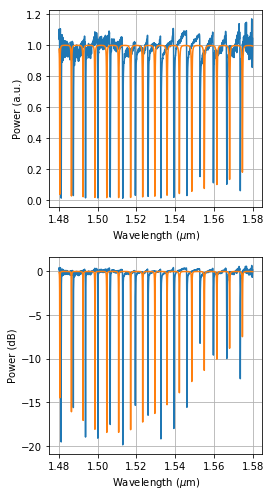

In [9]:
plotFinal(x0,y0,z0)